## Upsell 모델 remodeling

### 목적
- 최신 데이터 반영
 
### 모델링
- 기존과 동일한 feature, preprocessing

In [164]:
import lightgbm as lgb
import pandas as pd
import numpy as np
import pickle
import time
import os
import gc

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

from dateutil.relativedelta import relativedelta
from datetime import datetime

import shap
shap.initjs()

from tigger.util.hive_tools import hive_connection, load_from_hive, load_to_hive, send_query

In [165]:
from sm_utils import make_train_data

from multiprocessing import Pool
from functools import partial
import operator

In [167]:
DATA_PATH = '/home/dmig/work/upsell/data/'

In [168]:
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta

In [169]:
def next_month(ym):
    next_month = datetime.strptime(ym, '%Y%m') + relativedelta(months=1)
    return datetime.strftime(next_month, '%Y%m')

In [ ]:
tmp_sql = """
drop table dumbo.dominic_new_upsell_train_data;
create table dumbo.dominic_new_upsell_train_data as 
select 
    b.*
,   a.bf_prod_id as label_bf_prod_id
,   a.af_prod_id as label_af_prod_id
,   a.upsell as label_upsell
,   a.diff as label_diff
,   a.eqp_chg_yn as label_eqp_chg_yn
,   a.af_channel as label_af_channel
,   a.ym as a_ym
,   b.ym as b_ym
from comm.user_label_matrix_for_fee_no_equip_temp a
join comm.user_profile_pivot_monthly b
on a.svc_mgmt_num = b.svc_mgmt_num 
and b.ym = date_format(add_months(from_unixtime(unix_timestamp(a.ym,'yyyyMM'),'yyyy-MM-dd'),-1), 'yyyyMM')
where a.ym between '201907' and '201909'
and a.age between 19 and 70 
;
"""

### load data

In [170]:
sql = """
select *
from dumbo.dominic_new_upsell_train_data
"""

In [171]:
df = load_from_hive(hive_connection('dmig'), sql)

2019-10-30 10:12:16,848 - YE_HIVE - INFO - ...tmp_db name = tmp_20191030_10_12_16_8103d2065cd7de890050328c810f1931b8448146
2019-10-30 10:12:16,850 - YE_HIVE - INFO - Start creating table
2019-10-30 10:12:16,850 - YE_HIVE - INFO - drop table if exists dumbo.tmp_20191030_10_12_16_8103d2065cd7de890050328c810f1931b8448146
2019-10-30 10:12:16,902 - YE_HIVE - INFO - Query 'drop table if exists dumbo.tmp_20191030_10_12_16_8103d2065cd7de890050328c810f1931b8448146' is done
2019-10-30 10:15:05,940 - YE_HIVE - INFO - Query '
        create  table         dumbo.tmp_20191030_10_12_16_8103d2065cd7de890050328c810f1931b8448146 
        row format
        delimited fields terminated by '	'
        collection items terminated by ',' 
        map keys terminated by ':'
        lines terminated by '
'
        STORED AS PARQUET
        as
        
select *
from dumbo.dominic_new_upsell_train_data
' is done
2019-10-30 10:15:06,194 - YE_HIVE - INFO - Elapsed Time = 169.34
2019-10-30 10:15:06,196 - YE_HIVE - 

In [172]:
df.shape

(1833173, 434)

In [173]:
df.ym.value_counts()

201907    663451
201906    649082
201908    520640
Name: ym, dtype: int64

## preprocess

In [174]:
# null check
col_null_sum = df.isnull().sum()
print('null_cols: ', col_null_sum[col_null_sum>0])

null_cols:  nugu_app_use_days              1312533
nugu_btv_rgst_yn               1312533
nugu_btv_use_days              1312533
nugu_use_days                  1312533
family_moa_data_usage_in_gb    1312533
family_sharable_fee_prod_yn    1833173
nugu_user_yn                   1312533
nugu_dvc_rgst_yn               1312533
family_moa_share_data_in_gb    1312533
nugu_app_rgst_yn               1312533
main_channel_eqp_buy           1312533
nugu_dvc_use_days              1312533
dtype: int64


In [175]:
df.drop(list(col_null_sum[col_null_sum>0].index), axis=1, inplace=True)

In [178]:
filter_cols = [c for c in df.columns if 'filter_' in c]

df.drop(filter_cols), axis=1, inplace=True)

In [180]:
filter_cols

['filter_sex',
 'filter_svc_cd',
 'filter_block_obj_cl_cd',
 'filter_fee_prod',
 'filter_pps',
 'filter_smile',
 'filter_svc_st_cd',
 'filter_sktemployee',
 'filter_term_dt',
 'filter_svc_use_typ_cd',
 'filter_lte',
 'filter_agree_201',
 'filter_tfamilymoa',
 'filter_usim_indpnd_svc',
 'filter_eqp_mdl_cd',
 'filter_op_info_rejt_obj',
 'filter_alpa_cust',
 'filter_indv_corp_cl_cd',
 'filter_asgn_call_rgst_cust',
 'filter_col',
 'filter_agree_203',
 'filter_five_g',
 'filter_frgnr',
 'filter_trnd_info_rejt_obj']

In [181]:
zero_drop_list = ['tw_visit_days_fee_t_small', 'app_use_cnt_vr', 'tw_visit_days_vas_internet', 'tw_visit_days_vas_number_plus', 
                  'tw_visit_days_fee_senior_12g', 'tw_visit_days_vas_call_keeper', 'tw_visit_days_fee_t_large',
                  'tw_visit_days_wire_prod_list', 'mbr_discount_amt_theme_park', 'tw_visit_days_unbill', 'mbr_discount_cnt_coffee',
                  'tw_visit_days_vas_internet_family_comb', 'tw_visit_days_fee_t_infinity', 'tw_visit_days_vas_pooq', 
                  'tw_visit_days_fee_0_large', 'dsat_cnsl_cnt_bf_m2', 'mbr_discount_amt_sports', 
                  'mbr_discount_amt_beauty_and_fashion', 'tw_visit_days_fee_senior_save', 'mbr_discount_amt_chocolate', 
                  'tw_visit_days_tfamilymoa', 'mbr_discount_cnt_sports', 'tw_visit_days_vas_terminate', 'tw_visit_days_fee_t_ansim_4g',
                  'tw_visit_days_vas_my_smartcall', 'tw_visit_days_fee_t_save', 'tw_visit_days_fee_t_max',
                  'tw_visit_days_vas_call_available', 'mbr_discount_cnt_chocolate', 'tw_visit_days_fee_t_ansim_25g', 
                  'tw_visit_days_suspend', 'tw_visit_days_roaming_list', 'mbr_discount_cnt_jeju', 'tw_visit_days_vas_coloring', 
                  'mbr_discount_cnt_travel', 'app_use_traffic_shopping_parcel', 'tw_visit_days_fee_senior_with_t', 
                  'tw_visit_days_fee_t_family', 'mbr_discount_amt_travel', 'tw_visit_days_fee_0_small', 'tw_visit_days_fee_t_special',
                  'tw_visit_days_vas_calling_plus', 'dsat_cnsl_cnt_bf_m0', 'mbr_discount_amt_emart', 'mbr_discount_amt_transportation',
                  'mbr_discount_cnt_theme_park', 'mbr_discount_amt_coffee', 'tw_visit_days_fee_senior_22g', 'tw_visit_days_event', 
                  'tw_visit_days_vas_flo', 'tw_visit_days_fee_t_medium', 'mbr_discount_cnt_education', 'app_use_traffic_vr', 
                  'mbr_discount_amt_education', 'tw_visit_days_child_fee', 'tw_visit_days_fee_0_medium', 'tw_visit_days_vas_call_routing', 
                  'mbr_discount_cnt_transportation', 'mbr_discount_cnt_beauty_and_fashion', 'mbr_discount_amt_jeju', 'dsat_cnsl_cnt_bf_m1', 
                  'tw_visit_days_agentsearch', 'tw_visit_days_emailconsult', 'mbr_discount_cnt_music', 'mbr_discount_cnt_emart', 
                  'tw_visit_days_fee_t_regular', 'tw_visit_days_vas_perfect_call', 'mbr_discount_amt_music', 'sms_snd_cnt_sports', 
                  'sms_snd_cnt_student', 'sms_rcv_cnt_security', 'sms_snd_cnt_pet', 'voc_snd_cnt_security', 'voc_snd_cnt_wedding', 
                  'sms_snd_cnt_tax', 'voc_rcv_cnt_pet', 'sms_snd_cnt_restaurant', 'sms_rcv_cnt_home_move', 'sms_rcv_cnt_wedding', 
                  'voc_rcv_cnt_wedding', 'sms_snd_cnt_home_move', 'sms_snd_cnt_beauty', 'voc_rcv_cnt_security', 'sms_snd_cnt_security', 
                  'voc_rcv_cnt_interior', 'sms_snd_cnt_interior', 'sms_rcv_cnt_pet', 'sms_snd_cnt_wedding', 'sms_rcv_cnt_interior', 
                  'sms_snd_cnt_travel', 'voc_rcv_cnt_tax', 'sms_snd_cnt_baby', 'scrb_sta_dt', 'cust_birth_dt', 'cncl_aply_bf_equip_chg_dt', 
                  'svc_scrb_dt', 'fee_chg_dt', 'cncl_aply_last_equip_chg_dt'] + filter_cols

In [182]:
df.drop(zero_drop_list, axis=1, inplace=True)

In [183]:
df.shape

(1833173, 300)

## EDA

In [184]:
target = 'label_upsell'

In [185]:
df.groupby(['ym', 'label_upsell']).size()

ym      label_upsell
201906  N               196956
        Y               452126
201907  N               211031
        Y               452420
201908  N               171186
        Y               349454
dtype: int64

## 일반 변경 vs 기기변 요금제 
- 기변 제거

In [187]:
df.label_upsell.value_counts()/df.shape[0]

Y    0.68406
N    0.31594
Name: label_upsell, dtype: float64

In [189]:
602326/(602326+471000)

0.5611771260548986

In [188]:
df[df['label_eqp_chg_yn']=='N'].label_upsell.value_counts()

Y    602326
N    471000
Name: label_upsell, dtype: int64

In [190]:
df = df[df['label_eqp_chg_yn']=='N']

In [191]:
df.groupby(['ym', 'label_upsell']).size()

ym      label_upsell
201906  N               157931
        Y               219071
201907  N               169482
        Y               205160
201908  N               143587
        Y               178095
dtype: int64

## 채널 별로 특성
- 전체 모델링 vs 채널 별 모델링

In [196]:
df.label_af_channel.value_counts()

고객센터    451761
T월드     350796
오프라인    265696
N/A       5073
Name: label_af_channel, dtype: int64

In [195]:
df.label_af_channel.value_counts()/df.shape[0]

고객센터    0.420898
T월드     0.326831
오프라인    0.247545
N/A     0.004726
Name: label_af_channel, dtype: float64

In [193]:
for c in ['T월드', '고객센터', '오프라인']:
    df_tmp = df[df['label_af_channel']==c]
    print('='*50)
    print('channel: ', c)
    display(df_tmp.label_upsell.value_counts()/df_tmp.shape[0])

channel:  T월드


Y    0.546597
N    0.453403
Name: label_upsell, dtype: float64

channel:  고객센터


Y    0.721574
N    0.278426
Name: label_upsell, dtype: float64

channel:  오프라인


N    0.694621
Y    0.305379
Name: label_upsell, dtype: float64

## period 변수 EDA
- 지금은 요금제 변경 시점이 아닌 단순히 upsell vs downsell 모델링 이므로 그 시점에 대한 특성이 없음
- 때문에 모델 결과로 최근 요금제 변경한 고객(실제로 변경이 일어나지 않을) 고객이 나올 수 있음
- 그것ㄷ에 대해서 미리 살펴봄

col:  eqp_chg_period


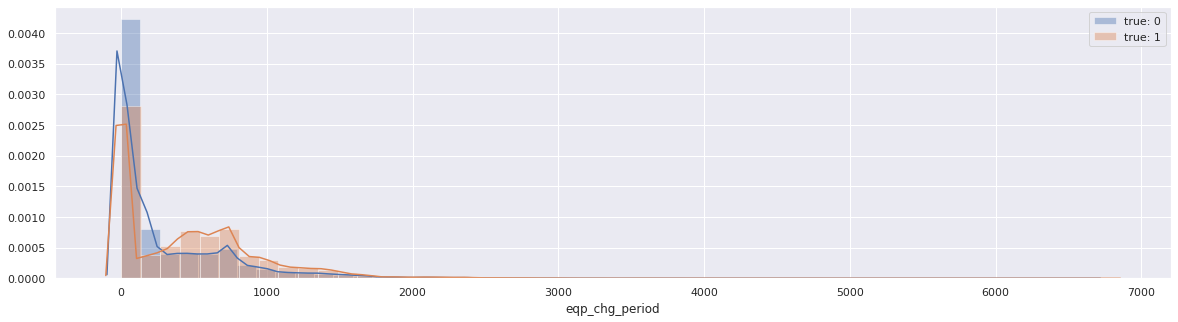

col:  avg_subscription_period


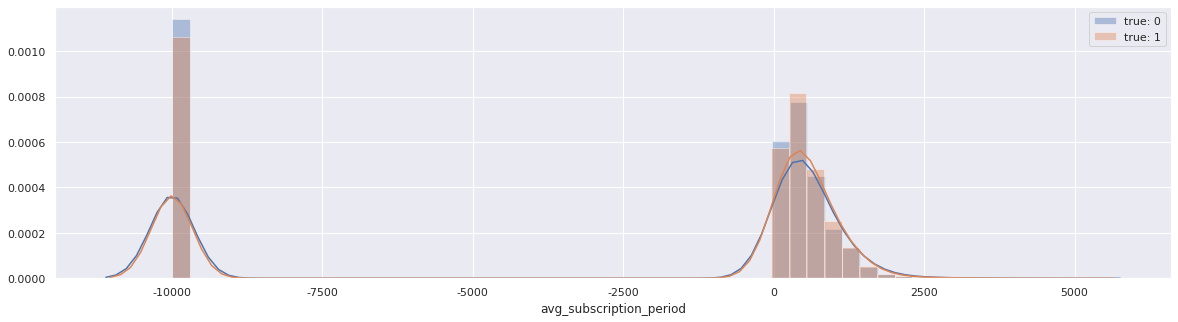

col:  fee_chg_period


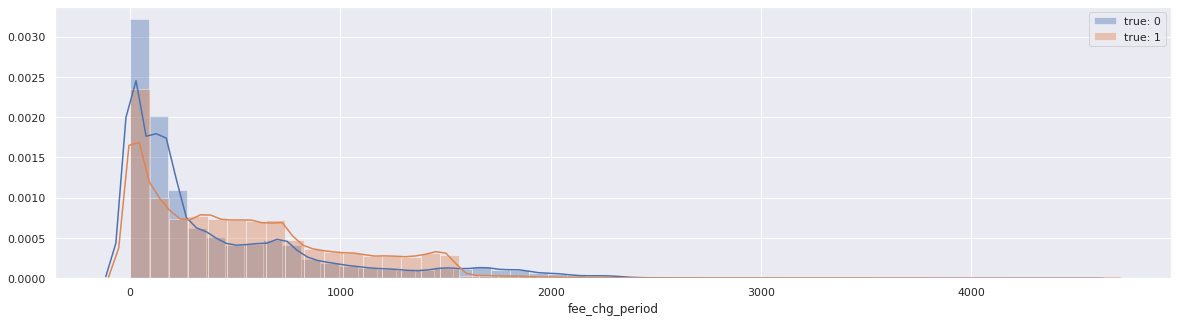

col:  svc_scrb_period


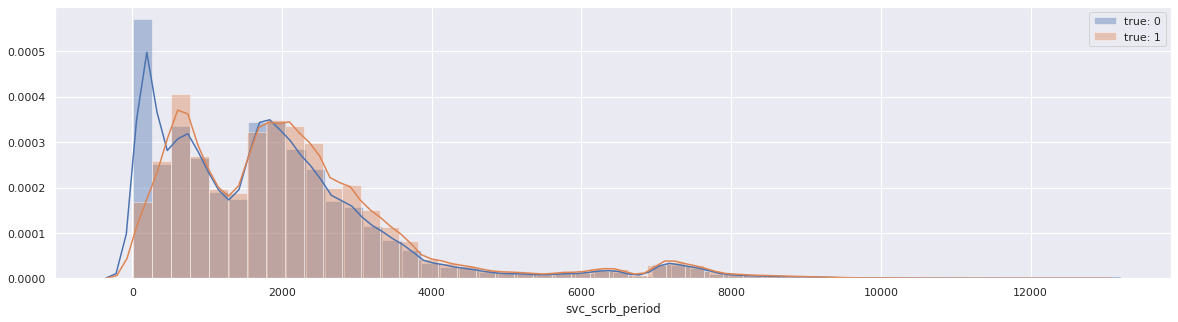

In [205]:
for c in [c for c in df.columns if '_period' in c]:
    print('='*50)
    print('col: ', c)
    sns.set(rc={'figure.figsize': (20, 5)})
    sns.distplot(df[df[target]=='N'][c], norm_hist=True, label='true: 0')
    sns.distplot(df[df[target]=='Y'][c], norm_hist=True, label='true: 1')
    plt.legend()
    plt.show()

## label encoding

In [230]:
from collections import defaultdict
from sklearn.preprocessing import LabelEncoder

cat_cols = list(df.select_dtypes(include=['object']).columns)

In [227]:
df.head()

svc_mgmt_num sex_cd   age  real_avg_arpu  roaming_cnt_m3  \
2    1000083601      1  53.0     63443.0000             0.0   
7    1014469403      1  58.0     17981.6667             4.0   
8    1016522206      1  52.0     60390.0000             0.0   
10   1026491402      1  41.0     41150.0000             0.0   
11   1028679304      2  36.0     45550.3333             0.0   

    last_eqp_buy_duration  location_weekday_visit_dong  \
2                    86.0                         14.0   
7                    10.0                         21.0   
8                   727.0                         37.0   
10                  176.0                         13.0   
11                  268.0                         11.0   

    mbr_discount_cnt_convenience_store  app_use_traffic_movie  \
2                                  0.0               0.000000   
7                                  0.0               0.000000   
8                                  0.0               0.000000   
10                                 1.0               4.301362   
11                                 5.0              13.483385   

    app_use_traffic_driver  ...  app_use_traffic_flo      ym  \
2                      0.0  ...             0.000000  201907   
7                      0.0  ...             0.000000  201907   
8                      0.0  ...             0.000000  201907   
10                     0.0  ...             6.714913  201907   
11                     0.0  ...             0.013806  201907   

    label_bf_prod_id  label_af_prod_id  label_upsell label_diff  \
2         NA00005017        NA00005483             N     -27825   
7         NA00004770        NA00006535             Y       3400   
8         NA00005293        NA00006535             N     -45000   
10        NA00004775        NA00006537             Y       3110   
11        NA00006537        NA00006534             N     -36000   

    label_eqp_chg_yn label_af_channel    a_ym    b_ym  
2                  N              T월드  201908  201907  
7                  N              T월드  201908  201907  
8                  N             고객센터  201908  201907  
10                 N             고객센터  201908  201907  
11                 N              T월드  201908  201907  

[5 rows x 300 columns]

In [208]:
label_cols = [c for c in cat_cols if 'label_' in c]
label_cols

['label_bf_prod_id',
 'label_af_prod_id',
 'label_upsell',
 'label_eqp_chg_yn',
 'label_af_channel']

In [231]:
cat_cols.remove('svc_mgmt_num')
cat_cols.remove('label_bf_prod_id')
cat_cols.remove('label_af_prod_id')
cat_cols.remove('label_eqp_chg_yn')
cat_cols.remove('label_af_channel')
cat_cols.remove('prod_nm') # debugging위해
cat_cols.remove('fee_prod_id') # bas_fee_amt와 중복
cat_cols.remove('a_ym')
cat_cols.remove('b_ym')

In [233]:
# label encodinng
d = defaultdict(LabelEncoder)
df[cat_cols] = df[cat_cols].apply(lambda x: d[x.name].fit_transform(x))

d.keys()

dict_keys(['sex_cd', 'eqp_mdl_cd', 'additional_svc_oksusu_scrb_type', 'data_gift_recv_yn_bf_m2', 'copn_data_u1_yn_bf_m0', 'channel', 'rmk_omd_yn', 'op_sale_chnl_cl_cd', 'smartwatch_yn', 'additional_svc_allcare_scrb_type', 'additional_svc_ansim_option_scrb_type', 'nh00000059_yn', 'data_gift_send_yn_bf_m0', 'job_cd', 'copn_data_u1_yn_bf_m1', 'childwatch_yn', 'family_marriage_yn', 'nm_cust_num', 'mbr_card_gr_cd', 'tablet_yn', 'additional_svc_flo_scrb_type', 'na00002040_yn', 'svc_gr_cd', 'family_yn', 'nh00000037_yn', 'sec_dev_yn', 'mng_nice_cb_scr', 'additional_svc_melon_scrb_type', 'nh00000084_yn', 'family_rep_yn', 'family_child_yn', 't_agr_t_eqpal_scrb_yn', 'nh00000133_yn', 'mng_nice_cb_grd', 'additional_svc_bugs_scrb_type', 'data_gift_recv_yn_bf_m0', 'nh00000114_yn', 'scrb_sale_chnl_cl_cd', 'data_gift_send_yn_bf_m1', 'nh00000103_yn', 'tmap_freq_dest_residence', 'nh00000039_yn', 'na00004430_yn', 'family_wire_comb_yn', 'additional_svc_pooq_scrb_type', 'family_small_yn', 'data_gift_send_yn

In [234]:
## save label encoder
with open(os.path.join(DATA_PATH, 'upsell_le_dict.pkl'), 'wb') as f:
    pickle.dump(d, f, protocol=pickle.HIGHEST_PROTOCOL)

In [235]:
df.to_pickle(os.path.join(DATA_PATH, 'upsell_1030.pkl'))

## modeling

In [236]:
df.label_af_channel.value_counts()

고객센터    0.420898
T월드     0.326831
오프라인    0.247545
N/A     0.004726
Name: label_af_channel, dtype: float64

In [238]:
df = df[df.label_af_channel!='N/A']

In [239]:
df.shape

(1068253, 300)

In [240]:
df.label_af_channel.value_counts()

고객센터    451761
T월드     350796
오프라인    265696
Name: label_af_channel, dtype: int64

In [241]:
def lgb_train(params, train_set, valid_sets):
    t1 = time.time()
    clf = lgb.train(lgb_params,
                    train_set=lgb_trn,
                    valid_sets=[lgb_trn, lgb_val],
                    num_boost_round=2000,
                    early_stopping_rounds=100,
                    verbose_eval=50)
    print('elapsed time:', time.time()-t1)
    return clf

In [242]:
from sklearn.model_selection import train_test_split

In [244]:
df_trn = df[df['b_ym']=='201906']
df_val = df[df['b_ym']=='201907']
df_tst = df[df['b_ym']=='201908']

df_trn.shape, df_val.shape, df_tst.shape

((371929, 300), (374642, 300), (321682, 300))

In [245]:
del df
import gc
gc.collect()

79266

In [266]:
label_cols = [c for c in df_trn.columns if 'label_' in c]
del_cols = ['svc_mgmt_num', 'ym', 'a_ym', 'b_ym', 'nm_cust_num', 'fee_prod_id', 'prod_nm']
del_cols += label_cols
feature_cols = [c for c in df_trn.columns if c not in del_cols]

In [267]:
feature_cols

['sex_cd',
 'age',
 'real_avg_arpu',
 'roaming_cnt_m3',
 'last_eqp_buy_duration',
 'location_weekday_visit_dong',
 'mbr_discount_cnt_convenience_store',
 'app_use_traffic_movie',
 'app_use_traffic_driver',
 'mbr_discount_amt_family_restaurant',
 'tw_visit_days_accessory',
 'mbr_discount_amt_shopping',
 'tw_visit_days_fee_t_essence',
 'mbr_discount_amt_convenience_store',
 'eqp_mdl_cd',
 'app_use_traffic_carsharing',
 'additional_svc_oksusu_scrb_type',
 'data_gift_recv_yn_bf_m2',
 'mbr_discount_cnt_shopping',
 'mbr_use_cnt',
 'avg_eqp_buy_duration',
 'avg_chg_duration',
 'mbr_discount_cnt_video',
 'voc_snd_avg_duration',
 'eqp_chg_period',
 'fee_chg_cnt',
 'twld_fee_visit_cnt_bf_m2',
 'app_use_traffic_stock',
 'data_usage_in_gb_bf_m2',
 'twld_visit_cnt_bf_m1',
 'bf_m3_data_over_usage_cnt',
 'app_use_cnt_bank',
 'eqp_out_prc',
 'real_arpu_bf_m1',
 'tw_visit_days_benefit',
 'app_use_traffic_youtube',
 'app_use_traffic_delivery',
 'voc_rcv_avg_duration',
 'copn_data_u1_yn_bf_m0',
 'bas_fee_amt',
 'day_traffic_hour_ratio',
 'channel',
 'tw_visit_days_remained_data',
 'voc_rcv_prtn_cnt_bf_m0',
 'app_use_cnt_pooq',
 'mbr_discount_amt_food_and_beverage',
 'app_use_traffic_shopping_store',
 't_agr_t_eqpal_scrb_mth_cnt',
 'voc_snd_cnt_travel',
 'mth_cnsl_cnt_bf_m2',
 'twld_fee_visit_cnt_bf_m1',
 'app_use_traffic_shopping_openmarket',
 'bf_m6_data_over_usage_cnt',
 'rmk_omd_yn',
 'location_weekend_visit_gu',
 'op_sale_chnl_cl_cd',
 'twld_visit_cnt_bf_m0',
 'avg_subscription_period',
 'sml_pay_cnt_bf_m2',
 'smartwatch_yn',
 'ref_data_usage_in_gb_bf_m2',
 'sml_pay_amt_bf_m1',
 'bf_m3_fee_chg_cnt',
 'simpl_ref_cnsl_cnt_bf_m0',
 'tw_visit_days_my_vas',
 'app_use_traffic_starbucks',
 'tw_visit_days_alacarte',
 'othr_co_icall_call',
 'mbr_discount_amt_mobile_and_media',
 'voc_rcv_cnt_travel',
 'app_use_traffic_pooq',
 'sms_rcv_cnt_baby',
 'app_use_traffic_shopping_coupon',
 'copn_left_cnt_bf1',
 'avg_twld_visit_cnt',
 'allot_prn_amt',
 'tw_visit_days_shopguide',
 'fee_chg_period',
 'app_use_traffic_svod',
 'additional_svc_allcare_scrb_type',
 'app_use_traffic_video_clip',
 'additional_svc_ansim_option_scrb_type',
 'app_use_traffic_insta',
 'nh00000059_yn',
 'tw_visit_days_my_fee',
 'mbr_discount_amt_11st',
 'app_use_traffic_reward',
 'data_gift_send_yn_bf_m0',
 'app_use_traffic_oksusu',
 'voc_snd_cnt_restaurant',
 'app_use_traffic_video',
 'real_arpu_bf_m2',
 'job_cd',
 'data_usage_in_gb_bf_m1',
 'tw_visit_days_vas_list',
 'voc_snd_cnt_baby',
 'copn_data_u1_yn_bf_m1',
 'app_use_traffic_naverband',
 'voc_rcv_cnt_home_move',
 'copn_left_cnt_bf2',
 'childwatch_yn',
 'app_use_traffic_cryptocurrency',
 'family_marriage_yn',
 'app_use_traffic_bugs',
 'app_use_traffic_public_tv',
 'voc_rcv_miss_cnt',
 'overage_bf2',
 'voc_rcv_cnt',
 'voc_rcv_prtn_cnt_bf_m1',
 'mbr_discount_amt_insurance',
 'twld_visit_cnt_bf_m2',
 'card_pay_cnt_bf_m0',
 'app_use_traffic_linkedin',
 'pmth_inv_bamt',
 'sml_pay_amt_bf_m2',
 'voc_rcv_cnt_beauty',
 'mbr_card_gr_cd',
 'tablet_yn',
 'app_use_cnt_oksusu',
 'location_weekday_visit_city',
 'mbr_discount_amt_movie',
 'family_comb_duration',
 'dcb_cnt_bf_m0',
 'additional_svc_flo_scrb_type',
 'sms_snd_cnt',
 'app_use_cnt_video',
 'location_weekend_visit_city',
 'na00002040_yn',
 'tw_visit_days_subsidy',
 'sms_rcv_cnt_beauty',
 'mbr_discount_amt_bakery',
 'location_weekend_visit_dong',
 'bf_m6_data_usage_ratio_avg',
 'app_use_traffic_bank_card',
 'dcb_amt_bf_m2',
 'mbr_discount_amt_pizza',
 'app_use_traffic_etc_music',
 'svc_gr_cd',
 'mbr_use_discount_amt',
 'family_yn',
 'voc_snd_prtn_cnt_bf_m1',
 'bf_m6_avg_data_usage_in_gb',
 'data_usage_in_gb_bf_m5',
 'tw_spd_chk_1m',
 'sms_rcv_cnt_restaurant',
 'nh00000037_yn',
 'tw_visit_days_realtime_bill',
 'app_use_cnt_bugs',
 'app_use_traffic_twitter',
 'app_use_traffic_simple_pay',
 'sec_dev_yn',
 'app_use_traffic_facebook',
 'real_data_use_gb_bf_m0',
 'app_use_cnt_music',
 'night_traffic_hour_ratio',
 'mng_nice_cb_scr',
 'additional_svc_melon_scrb_type',
 'app_use_traffic_podcast',
 '

In [268]:
# best parameters
lgb_params = {
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': 'auc',
    'is_unbalance': True,
    'num_leaves': 31,
    'learning_rate': 0.05,
    'num_threads': 50,
}

In [269]:
from sm_utils import sampling, evaluate, save_model, load_model

channel:  고객센터
Training until validation scores don't improve for 100 rounds.
[50]	training's auc: 0.921066	valid_1's auc: 0.917646
[100]	training's auc: 0.931692	valid_1's auc: 0.926486
[150]	training's auc: 0.937523	valid_1's auc: 0.930438
[200]	training's auc: 0.941764	valid_1's auc: 0.932229
[250]	training's auc: 0.945294	valid_1's auc: 0.933067
[300]	training's auc: 0.948223	valid_1's auc: 0.933384
[350]	training's auc: 0.950859	valid_1's auc: 0.933686
[400]	training's auc: 0.953175	valid_1's auc: 0.933971
[450]	training's auc: 0.955386	valid_1's auc: 0.934174
[500]	training's auc: 0.957476	valid_1's auc: 0.934417
[550]	training's auc: 0.959418	valid_1's auc: 0.934595
[600]	training's auc: 0.961213	valid_1's auc: 0.934622
[650]	training's auc: 0.962866	valid_1's auc: 0.93466
[700]	training's auc: 0.964506	valid_1's auc: 0.934663
[750]	training's auc: 0.966019	valid_1's auc: 0.934675
[800]	training's auc: 0.967431	valid_1's auc: 0.934697
[850]	training's auc: 0.968695	valid_1's auc

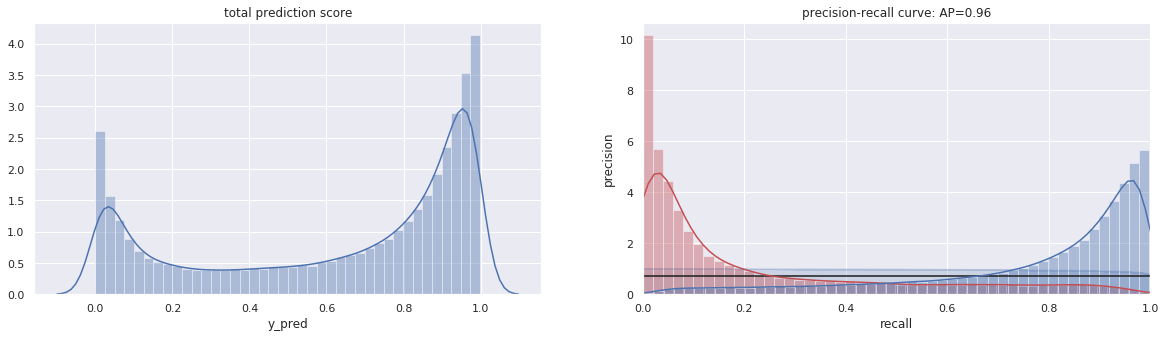

channel:  T월드
Training until validation scores don't improve for 100 rounds.
[50]	training's auc: 0.883411	valid_1's auc: 0.888462
[100]	training's auc: 0.899961	valid_1's auc: 0.900577
[150]	training's auc: 0.908686	valid_1's auc: 0.906013
[200]	training's auc: 0.914637	valid_1's auc: 0.908855
[250]	training's auc: 0.919566	valid_1's auc: 0.910295
[300]	training's auc: 0.923748	valid_1's auc: 0.911285
[350]	training's auc: 0.927568	valid_1's auc: 0.911796
[400]	training's auc: 0.931117	valid_1's auc: 0.912195
[450]	training's auc: 0.934488	valid_1's auc: 0.912524
[500]	training's auc: 0.937592	valid_1's auc: 0.912671
[550]	training's auc: 0.940565	valid_1's auc: 0.912792
[600]	training's auc: 0.94327	valid_1's auc: 0.912902
[650]	training's auc: 0.945955	valid_1's auc: 0.91299
[700]	training's auc: 0.948431	valid_1's auc: 0.913069
[750]	training's auc: 0.950879	valid_1's auc: 0.91318
[800]	training's auc: 0.953218	valid_1's auc: 0.913252
[850]	training's auc: 0.955322	valid_1's auc: 0

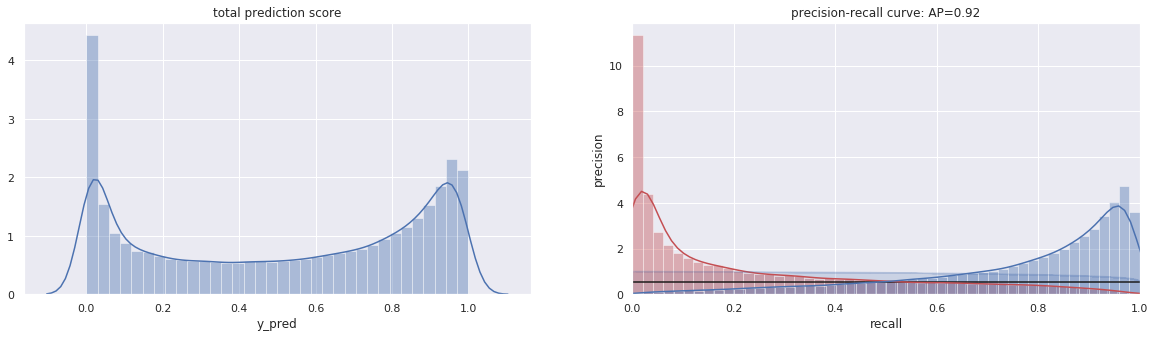

channel:  오프라인
Training until validation scores don't improve for 100 rounds.
[50]	training's auc: 0.936674	valid_1's auc: 0.923928
[100]	training's auc: 0.946713	valid_1's auc: 0.932124
[150]	training's auc: 0.952572	valid_1's auc: 0.935414
[200]	training's auc: 0.956829	valid_1's auc: 0.936642
[250]	training's auc: 0.960411	valid_1's auc: 0.937253
[300]	training's auc: 0.963619	valid_1's auc: 0.937504
[350]	training's auc: 0.966502	valid_1's auc: 0.937797
[400]	training's auc: 0.969024	valid_1's auc: 0.937887
[450]	training's auc: 0.971328	valid_1's auc: 0.93796
[500]	training's auc: 0.973559	valid_1's auc: 0.937993
[550]	training's auc: 0.975546	valid_1's auc: 0.938045
[600]	training's auc: 0.977396	valid_1's auc: 0.938
[650]	training's auc: 0.979065	valid_1's auc: 0.93798
Early stopping, best iteration is:
[554]	training's auc: 0.975705	valid_1's auc: 0.938046
elapsed time: 10.632862329483032
        acc    recall  precision  f1_score       auc
0  0.858394  0.874529   0.724181  0.7

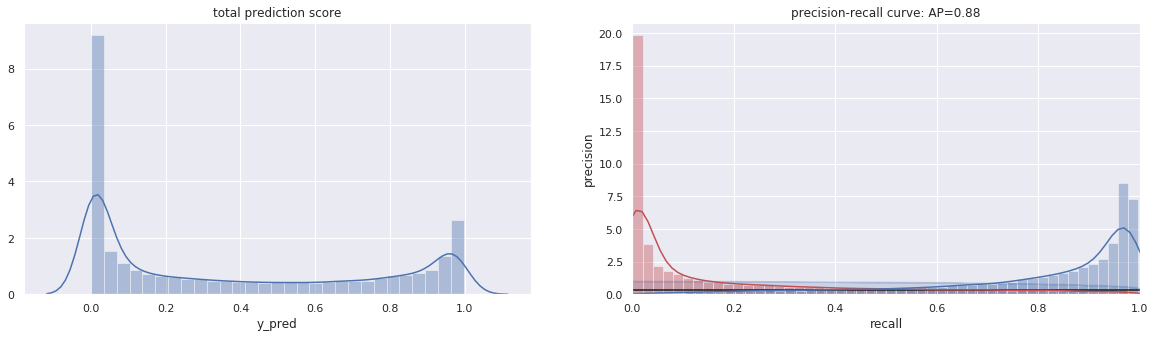

In [270]:
clf_dict = {}
for c in ['고객센터', 'T월드', '오프라인']:
    print('='*50)
    print('channel: ', c)
    
    df_trn_tmp = df_trn[df_trn['label_af_channel']==c]
    df_val_tmp = df_val[df_val['label_af_channel']==c]
    df_tst_tmp = df_tst[df_tst['label_af_channel']==c]
    
    # train
    lgb_trn = lgb.Dataset(df_trn_tmp[feature_cols], df_trn_tmp[target], feature_name=feature_cols)
    lgb_val = lgb.Dataset(df_val_tmp[feature_cols], df_val_tmp[target], feature_name=feature_cols)
    clf = lgb_train(lgb_params, lgb_trn, [lgb_trn, lgb_val])
    
    # evaluate
    eval_result = evaluate(df_tst_tmp[feature_cols], df_tst_tmp[target].values, clf, clf_name='lgb')
    
    # save
    clf_dict[c] = clf

In [271]:
clf_dict

{'고객센터': <lightgbm.basic.Booster at 0x7f916bd7d828>,
 'T월드': <lightgbm.basic.Booster at 0x7f9005623c50>,
 '오프라인': <lightgbm.basic.Booster at 0x7f8fffcfa518>}

## process for offline test

In [14]:
from item_reco_test_binary_post import OfflineTest4Binary

In [15]:
ot4b = OfflineTest4Binary(
    reco_type='upsell',
    test_ym='201907',
    model=clf,
    model_name='dominic_lgbm_08_20191011',
    feature_cols=clf.feature_name()
)

init +++
reco_type:  upsell
prod_id:  RC00000001
prod_nm:  요금제업셀가망
test_ym:  201907
model_name:  dominic_lgbm_08_20191011
feature_cols:  ['sex_cd', 'age', 'svc_gr', 'mng_nice_cb_scr', 'mng_nice_cb_grd', 'svc_scrb_period', 'last_equip_period', 'bas_fee_amt', 'bas_ofr_data_gb', 'eqp_out_prc', 'allot_prn_amt', 'pmth_inv_bamt', 'family_yn', 'family_small_yn', 'twld_visit_cnt_bf_m0', 'twld_visit_cnt_bf_m1', 'twld_visit_cnt_bf_m2', 'avg_twld_visit_cnt', 'twld_fee_visit_cnt_bf_m0', 'twld_fee_visit_cnt_bf_m1', 'twld_fee_visit_cnt_bf_m2', 'avg_twld_fee_visit_cnt', 'ansim_yn', 'ref_data_usage_in_gb_bf_m0', 'ref_data_usage_in_gb_bf_m1', 'ref_data_usage_in_gb_bf_m2', 'data_usage_in_gb_bf_m0', 'data_usage_in_gb_bf_m1', 'data_usage_in_gb_bf_m2', 'avg_data_usage_in_gb', 'overage_bf0', 'overage_bf1', 'overage_bf2', 'copn_data_u1_yn_bf_m0', 'copn_data_u1_yn_bf_m1', 'copn_data_u1_yn_bf_m2', 'data_gift_send_yn_bf_m0', 'data_gift_send_yn_bf_m1', 'data_gift_send_yn_bf_m2', 'data_gift_recv_yn_bf_m0', 'data_

In [16]:
ot4b.one_shot(df_mart07)

one_shot +++
submit_to_item_reco_test +++
load_to_comm_table +++
load to dumbo table +++
2019-10-11 07:22:59,170 - YE_HIVE - INFO - Query 'CREATE TABLE IF NOT EXISTS dumbo.item_reco_test_upsell (                        svc_mgmt_num string, prod_id string, prod_nm string, score double, reco_type string, model string, ym string )                        row format delimited
fields terminated by '\t' stored as textfile' is done
2019-10-11 07:22:59,193 - YE_HIVE - INFO - save dataframe for textfile format... 
2019-10-11 07:24:32,819 - YE_HIVE - INFO - Loading data to HDFS... 
2019-10-11 07:24:51,799 - YE_HIVE - INFO - Loading to table dumbo.item_reco_test_upsell is done
insert to comm table +++
2019-10-11 07:25:08,057 - YE_HIVE - INFO - Query '
            INSERT  OVERWRITE TABLE comm.item_reco_test PARTITION (reco_type, model, ym)
            SELECT  *
            FROM    dumbo.item_reco_test_upsell
        ' is done
drop dumbo table +++
2019-10-11 07:25:08,711 - YE_HIVE - INFO - Query 'dr

## Interpretable ML
- 서비스 나갈만한 모델인가?
- 모델이 어떤 특성으로 회선들을 예측하는지 이해해보자
- 그 방식이 resonable 한가?
    - 이상하다면?? -> todo_list를 만들고 추후에 변경

## How? & What?

1. Global interpretability
    - 전체적으로 봤을 때, 각각의 feature가 model output에 얼마나 영향을 미치는지? -> feature importance
    ex) 비싼 요금제를 쓰는 고객들이 5g 단말기를 사는 경향이 있다
2. Local interpretability
    - 개별 data point에 대한 model output 산출 이유
    ex) 해당 고객이 5g 단말기 살 가능성이 높은 이유는, '가입한지 2년이 됐고 이전 요금제가 비싸고 옥수수에 가입했기 때문'이다.



### model feature importance

In [272]:
for c in clf_dict.keys():
    print('='*50)
    print('c: ', c)
    display(pd.DataFrame({'feature': clf_dict[c].feature_name(), 
                          'importance': clf_dict[c].feature_importance()}).sort_values('importance', ascending=False).head(20))

c:  고객센터


feature  importance
39                  bas_fee_amt        1421
77               fee_chg_period         794
236     bas_ofr_data_gb_qty_val         662
1                           age         580
132  bf_m6_data_usage_ratio_avg         508
273       t_agr_t_eqpal_scrb_ym         441
234                 voc_srv_cnt         334
33              real_arpu_bf_m1         317
23         voc_snd_avg_duration         311
152      real_data_use_gb_bf_m0         286
14                   eqp_mdl_cd         282
40       day_traffic_hour_ratio         266
67           othr_co_icall_call         260
37         voc_rcv_avg_duration         256
24               eqp_chg_period         256
155             mng_nice_cb_scr         254
32                  eqp_out_prc         254
184             svc_scrb_period         254
161              skt_icall_call         244
121        family_comb_duration         243

c:  T월드


feature  importance
39                  bas_fee_amt        1516
77               fee_chg_period         673
1                           age         669
236     bas_ofr_data_gb_qty_val         568
132  bf_m6_data_usage_ratio_avg         489
273       t_agr_t_eqpal_scrb_ym         414
152      real_data_use_gb_bf_m0         384
234                 voc_srv_cnt         367
14                   eqp_mdl_cd         337
32                  eqp_out_prc         328
33              real_arpu_bf_m1         310
23         voc_snd_avg_duration         306
24               eqp_chg_period         299
184             svc_scrb_period         295
178                 sms_rcv_cnt         293
124                 sms_snd_cnt         289
142      data_usage_in_gb_bf_m5         289
40       day_traffic_hour_ratio         279
155             mng_nice_cb_scr         277
57      avg_subscription_period         268

c:  오프라인


feature  importance
39                  bas_fee_amt        1256
1                           age         572
236     bas_ofr_data_gb_qty_val         446
77               fee_chg_period         369
234                 voc_srv_cnt         322
24               eqp_chg_period         282
132  bf_m6_data_usage_ratio_avg         272
273       t_agr_t_eqpal_scrb_ym         258
155             mng_nice_cb_scr         216
184             svc_scrb_period         204
32                  eqp_out_prc         203
40       day_traffic_hour_ratio         201
121        family_comb_duration         187
14                   eqp_mdl_cd         182
124                 sms_snd_cnt         181
37         voc_rcv_avg_duration         177
33              real_arpu_bf_m1         176
23         voc_snd_avg_duration         169
178                 sms_rcv_cnt         167
139                   family_yn         164

- top 20 살펴보기
- label 별 분포

In [273]:
from eda_tools import numeric_eda_plot, categorical_eda_plot

c:  고객센터
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
LABEL COUNTS : {0: 100000, 1: 100000}
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!



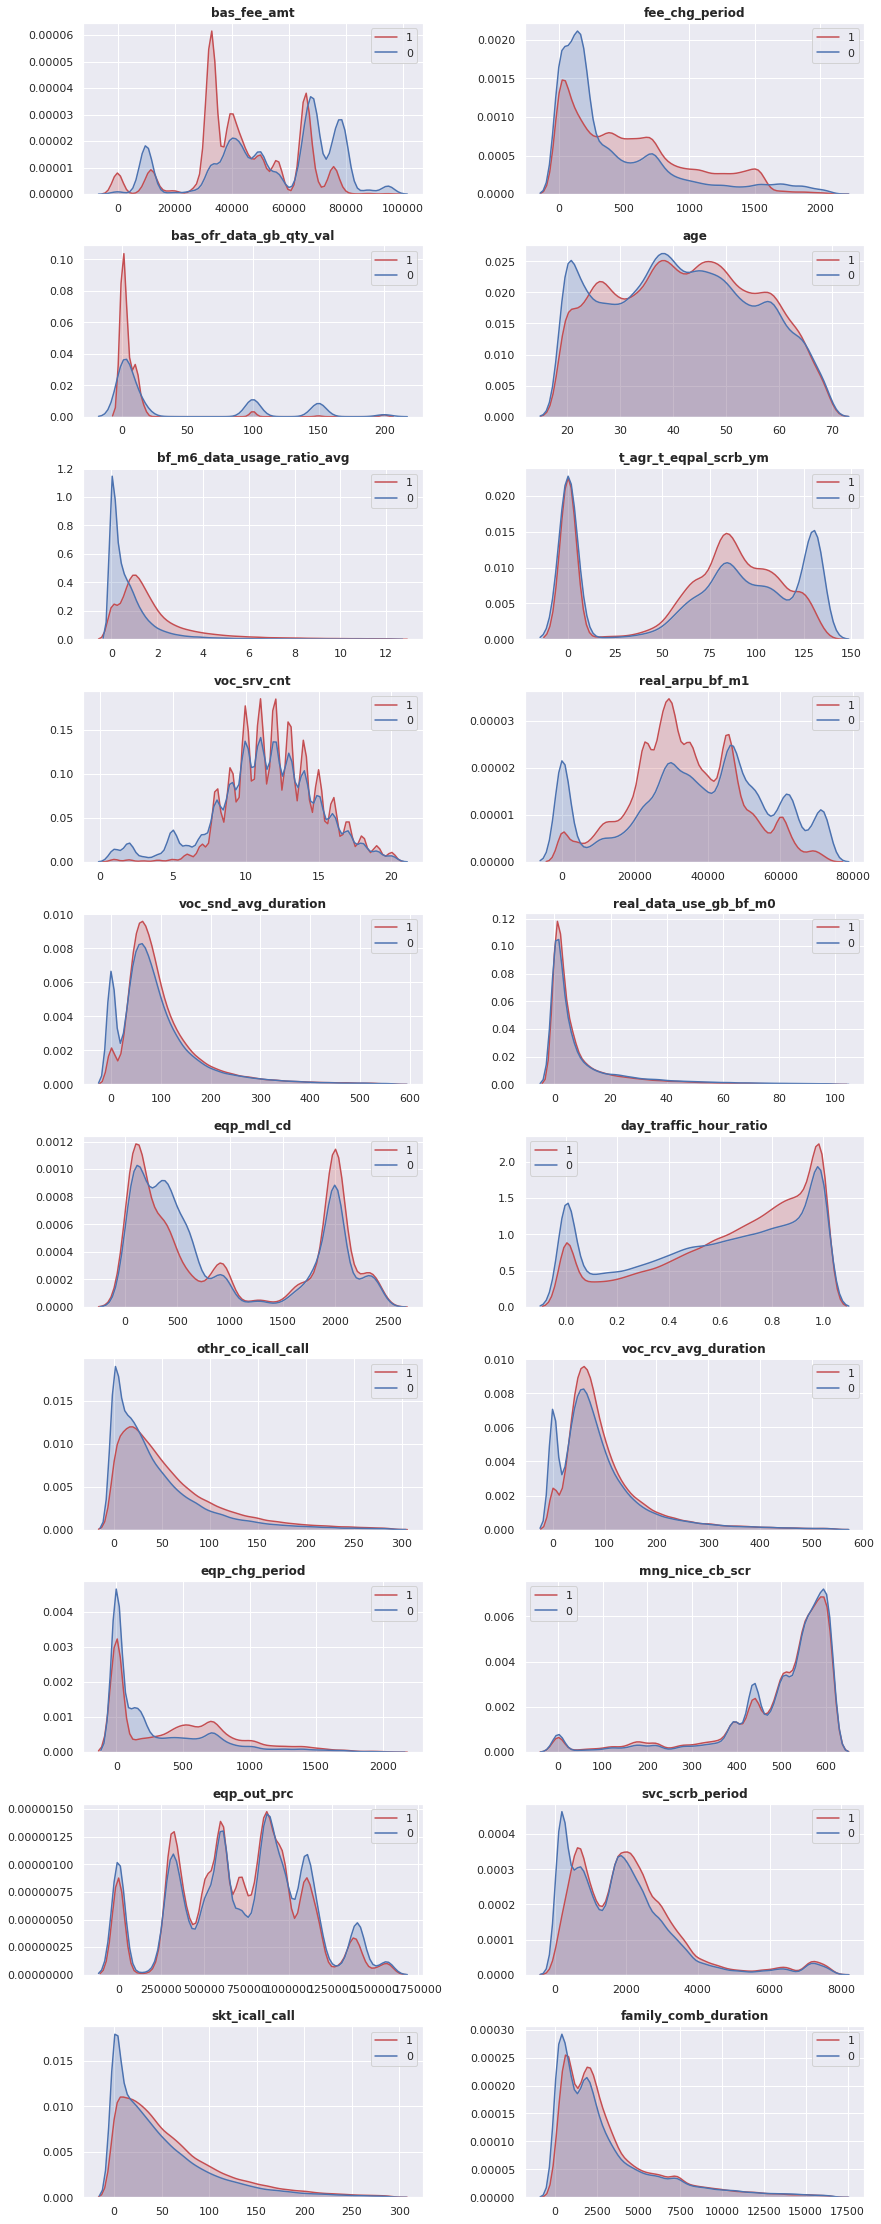

In [275]:
c = '고객센터'

print('='*50)
print('c: ', c)
top20_cols = list(pd.DataFrame({'feature': clf_dict[c].feature_name(), 
                                'importance': clf_dict[c].feature_importance()}).sort_values('importance', ascending=False).head(20).feature)
numeric_eda_plot(df_tst, top20_cols, 'label_upsell', n_samples=100000)

c:  T월드
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
LABEL COUNTS : {0: 100000, 1: 100000}
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!



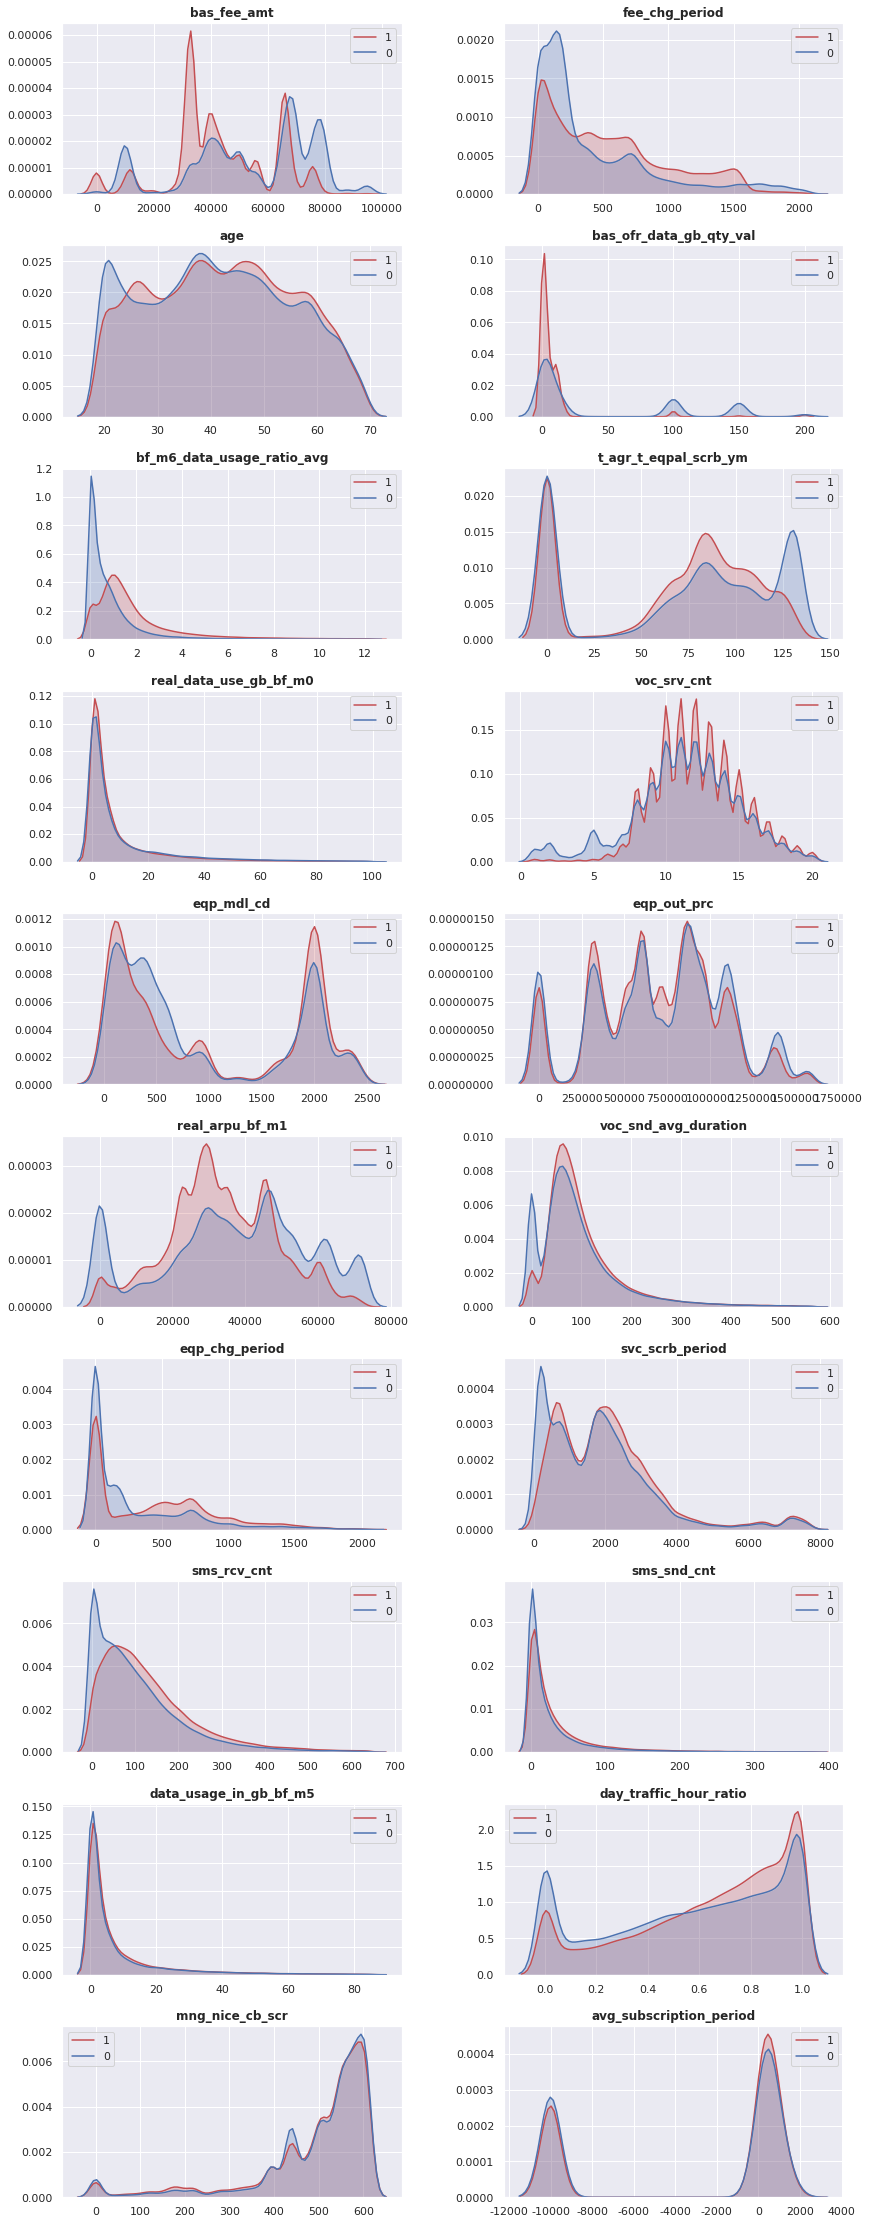

In [276]:
c = 'T월드'
print('='*50)
print('c: ', c)
top20_cols = list(pd.DataFrame({'feature': clf_dict[c].feature_name(), 
                                'importance': clf_dict[c].feature_importance()}).sort_values('importance', ascending=False).head(20).feature)
numeric_eda_plot(df_tst, top20_cols, 'label_upsell', n_samples=100000)

c:  오프라인
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
LABEL COUNTS : {0: 100000, 1: 100000}
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!



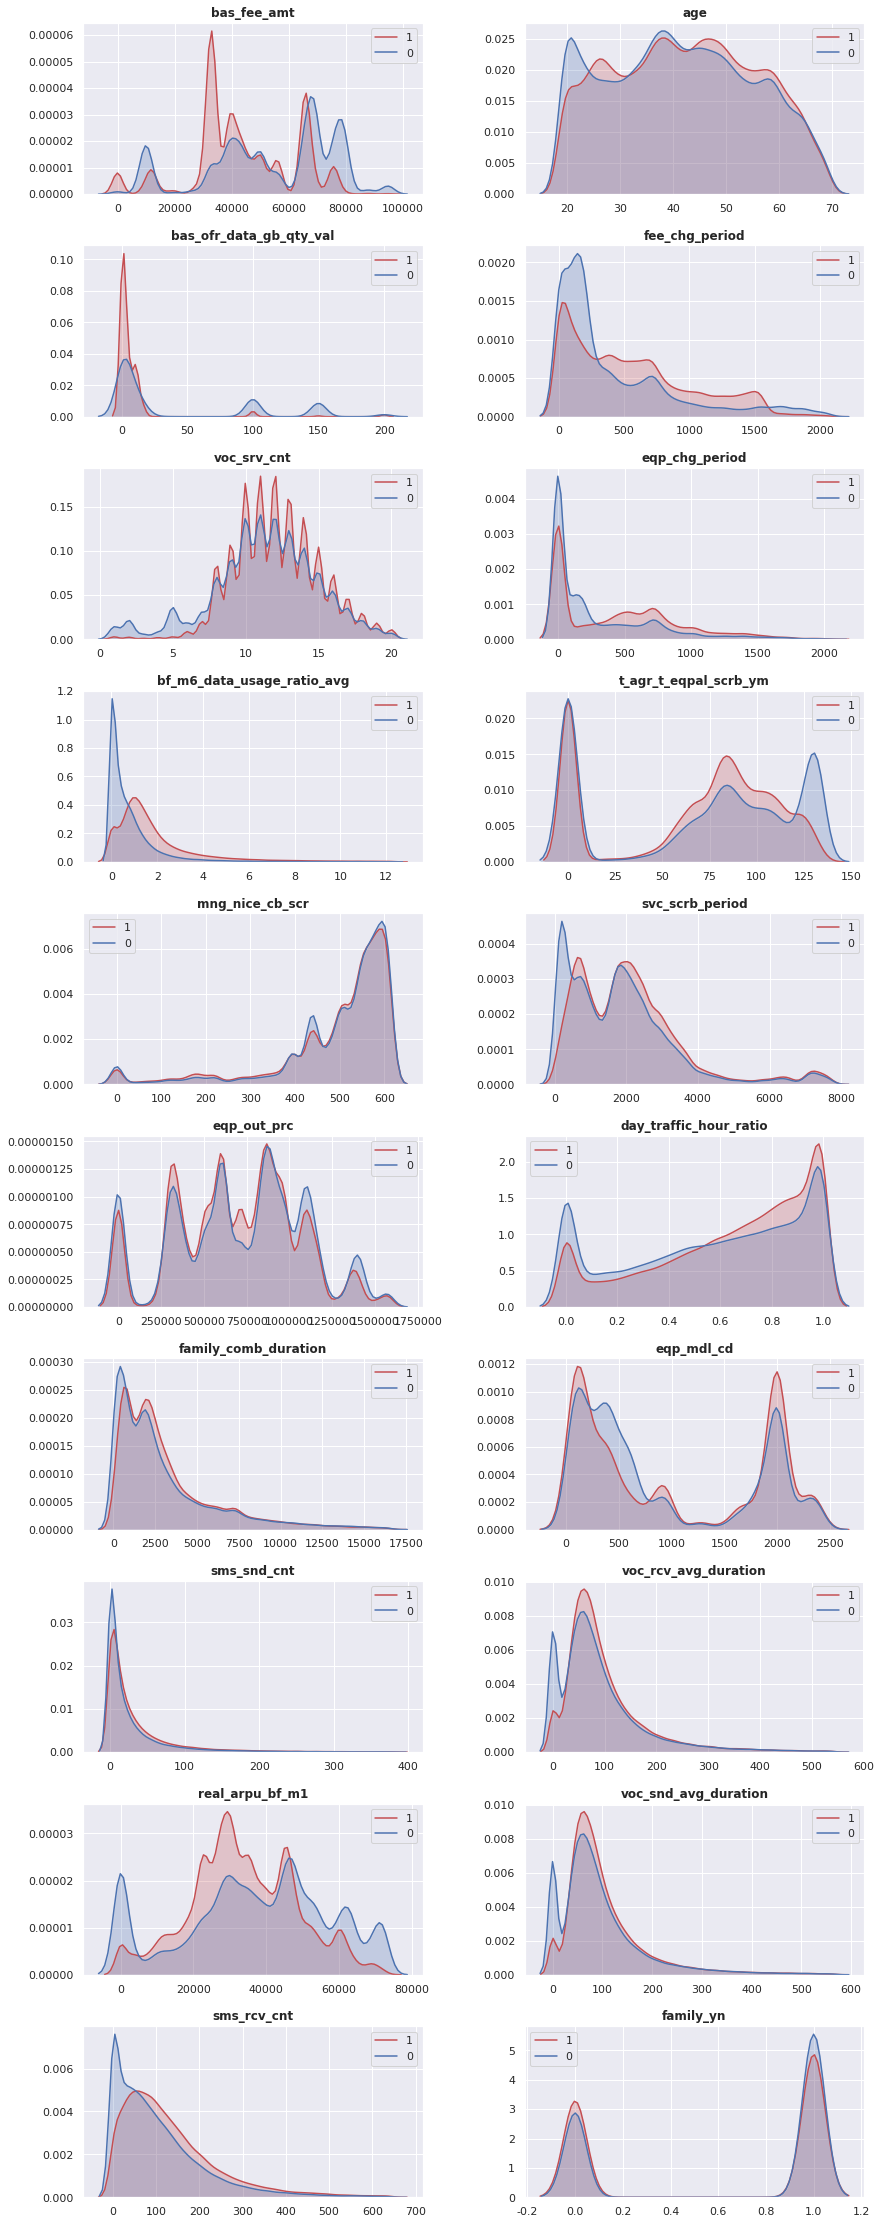

In [277]:
c = '오프라인'
print('='*50)
print('c: ', c)
top20_cols = list(pd.DataFrame({'feature': clf_dict[c].feature_name(), 
                                'importance': clf_dict[c].feature_importance()}).sort_values('importance', ascending=False).head(20).feature)
numeric_eda_plot(df_tst, top20_cols, 'label_upsell', n_samples=100000)

## shap value

In [278]:
from shap_tools import ShapModule

In [280]:
from shap_tools import ShapModule

In [281]:
shap_dict = {}

In [282]:
for c in clf_dict.keys():
    shap_dict[c] = ShapModule(df_trn, clf_dict[c], feature_cols, 'svc_mgmt_num', 'label_upsell', label_dict={0:'N', 1:'Y'})

init!
<class 'lightgbm.basic.Booster'>
init!
<class 'lightgbm.basic.Booster'>
init!
<class 'lightgbm.basic.Booster'>


In [283]:
for c, sm in shap_dict.items():
    sm.calculate_shap_value()

elapsed time:  53.268463373184204
elapsed time:  61.48487877845764
elapsed time:  32.97644925117493


In [284]:
shap_dict.keys()

dict_keys(['고객센터', 'T월드', '오프라인'])

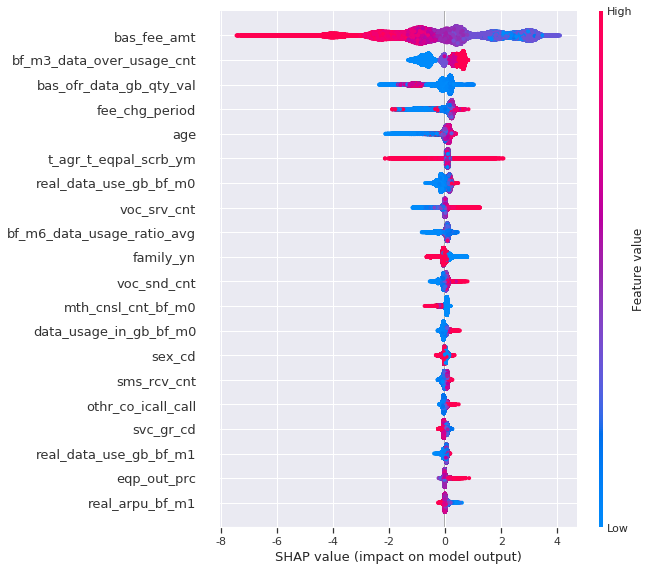

In [285]:
shap_dict['고객센터'].summary_plot(max_display=20)

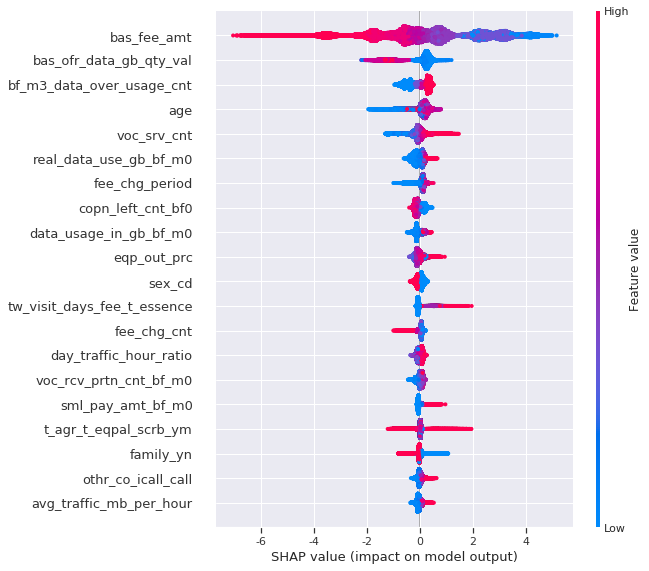

In [286]:
shap_dict['T월드'].summary_plot(max_display=20)

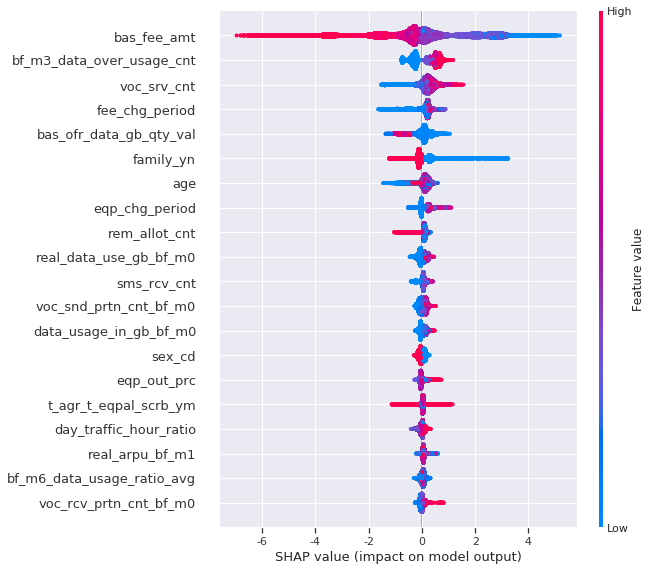

In [287]:
shap_dict['오프라인'].summary_plot(max_display=20)

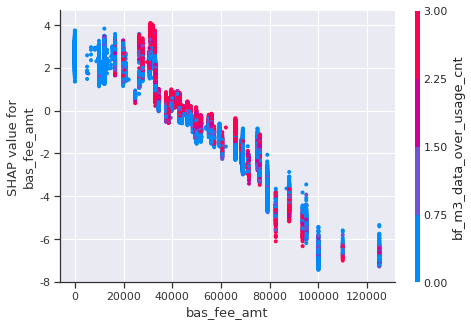

In [288]:
shap_dict['고객센터'].dependence_plot('bas_fee_amt')

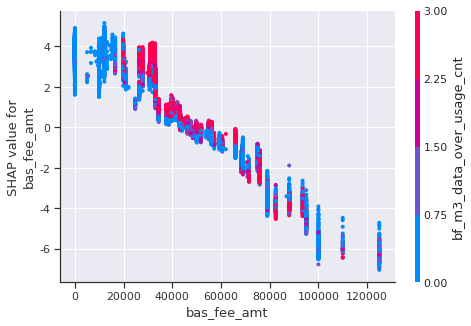

In [289]:
shap_dict['T월드'].dependence_plot('bas_fee_amt')

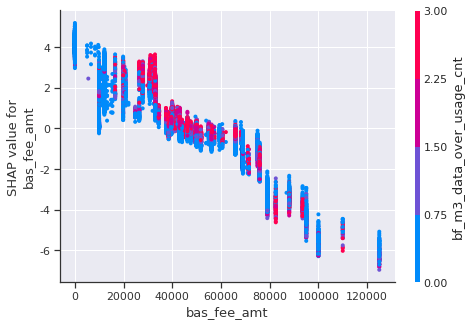

In [290]:
shap_dict['오프라인'].dependence_plot('bas_fee_amt')

## 전체 고객

Training until validation scores don't improve for 100 rounds.
[50]	training's auc: 0.907999	valid_1's auc: 0.908767
[100]	training's auc: 0.919367	valid_1's auc: 0.918903
[150]	training's auc: 0.924914	valid_1's auc: 0.923548
[200]	training's auc: 0.928483	valid_1's auc: 0.9263
[250]	training's auc: 0.931117	valid_1's auc: 0.928134
[300]	training's auc: 0.933202	valid_1's auc: 0.929239
[350]	training's auc: 0.93501	valid_1's auc: 0.930065
[400]	training's auc: 0.936508	valid_1's auc: 0.930538
[450]	training's auc: 0.937884	valid_1's auc: 0.930914
[500]	training's auc: 0.939163	valid_1's auc: 0.931181
[550]	training's auc: 0.940329	valid_1's auc: 0.931285
[600]	training's auc: 0.94146	valid_1's auc: 0.931442
[650]	training's auc: 0.942589	valid_1's auc: 0.931617
[700]	training's auc: 0.943585	valid_1's auc: 0.931692
[750]	training's auc: 0.944606	valid_1's auc: 0.931782
[800]	training's auc: 0.945558	valid_1's auc: 0.931874
[850]	training's auc: 0.946509	valid_1's auc: 0.931969
[900]	t

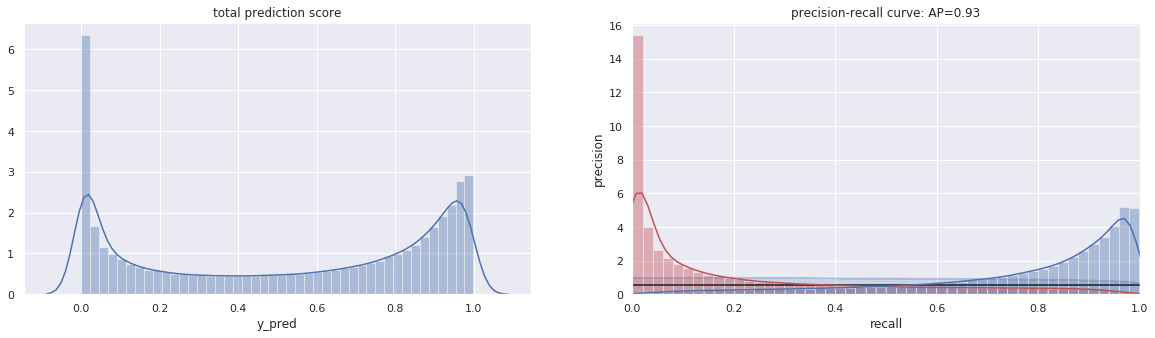

In [291]:
# train
lgb_trn = lgb.Dataset(df_trn[feature_cols], df_trn[target], feature_name=feature_cols)
lgb_val = lgb.Dataset(df_val[feature_cols], df_val[target], feature_name=feature_cols)
clf = lgb_train(lgb_params, lgb_trn, [lgb_trn, lgb_val])

# evaluate
eval_result = evaluate(df_tst[feature_cols], df_tst[target].values, clf, clf_name='lgb')

# save
clf_dict['total'] = clf

## 새로운 모델 비교
- 8월 input 전체 고객 prediction -> 9월 label을 가지고 upsell accuracy, diff 계산 & prod_nm 분포 확인
- 9월 input 전체 고객 prediction -> prod_nm 분포

## top 50 feature selection

In [292]:
df_fea = pd.DataFrame({'feature': clf_dict['total'].feature_name(),
                       'importance': clf_dict['total'].feature_importance()})

In [310]:
feature_cols = df_fea.sort_values('importance', ascending=False).head(100).feature.values

In [311]:
label_cols

['label_bf_prod_id',
 'label_af_prod_id',
 'label_upsell',
 'label_diff',
 'label_eqp_chg_yn',
 'label_af_channel']

In [312]:
idx_cols = ['svc_mgmt_num', 'fee_prod_id', 'prod_nm']

In [313]:
new_feature_cols = list(idx_cols) + list(feature_cols) + list(label_cols)

In [314]:
with open(os.path.join(DATA_PATH, 'new_features.pkl'), 'wb') as f:
    pickle.dump(new_feature_cols, f)